In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# import pdb
import re
# import os
import time
#from pathlib import Path
#import pickle
#import random
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
pos = pd.read_csv('possitive_case.csv')
neg = pd.read_csv('negative_case.csv')

In [3]:
neg_columns = ['Unnamed: 0','marketplace','star_rating','helpful_votes','total_votes','verified_purchase','review_headline','review_date','product_title']

In [4]:
neg_reviews_df = neg.drop(columns=neg_columns)

In [5]:
pos['Status'] = 1

In [6]:
pos_reviews_df = pos.drop(columns=neg_columns)

In [7]:
join = [pos_reviews_df,neg_reviews_df]

In [8]:
joined = pd.concat(join)

In [9]:
len(joined)

311311

In [10]:
joined = joined.dropna()

In [11]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311303 entries, 0 to 157550
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_body  311303 non-null  object
 1   Status       311303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.1+ MB


In [12]:
joined.head()

,review_body,Status
0,"Easy read, second part to the book If I Stay. ...",1
1,Husband loved it!,1
2,A friend recommended this and I'll pass to you...,1
3,Very good item. Quick delivery.,1
4,Enjoyed this book. Looking forward to a seque...,1


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

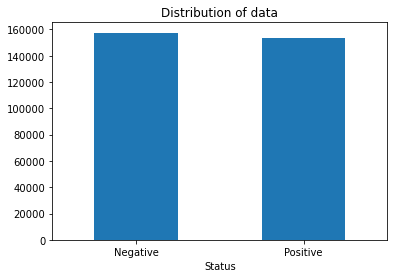

In [13]:
ax = joined.groupby('Status').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


In [14]:
text, status = list(joined['review_body']), list(joined['Status'])


In [15]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Url_Pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
User_Pattern = '@[^\s]+'
Alph_Num_Pattern = "[^a-zA-Z0-9]"
Repeat_Pattern = r"(.)\1\1+"
Replace_Pattern = r"\1\1"

def process_words(text):
    processed_text = []
    wordLemm = WordNetLemmatizer()
    for review in text:
        review = re.sub(Alph_Num_Pattern, ' ', review)
        review = review.lower()
        review = re.sub(Url_Pattern, 'Url', review)
        for emoji in emojis.keys():
            review = review.replace(emoji, emojis[emoji])
        review = re.sub(User_Pattern, 'User', review)
        review = re.sub(Repeat_Pattern, Replace_Pattern, review)
        review_words = ''
        for word in review.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                review_words += (word+' ')
                
        processed_text.append(review_words)
    return processed_text
    

In [16]:
t = time.time()
processedtext = process_words(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 77 seconds


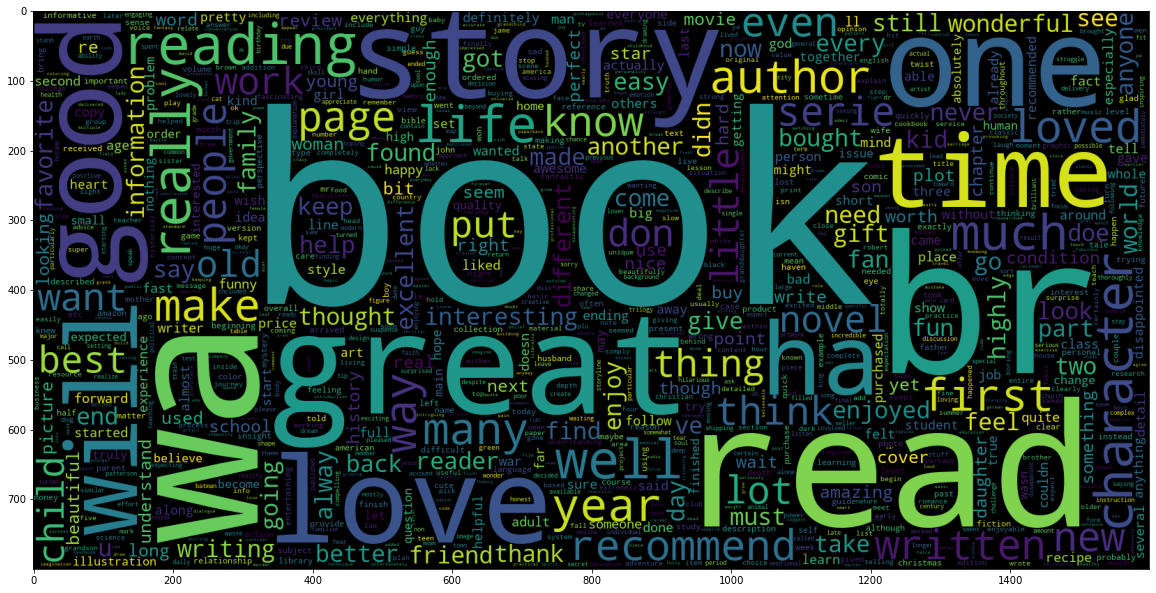

In [17]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(processedtext))
plt.imshow(wc)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, status,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [19]:
len(X_train)


249042

In [75]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=400000)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  400000


In [21]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.68      0.80      0.74     31484
           1       0.76      0.62      0.68     30777

    accuracy                           0.71     62261
   macro avg       0.72      0.71      0.71     62261
weighted avg       0.72      0.71      0.71     62261



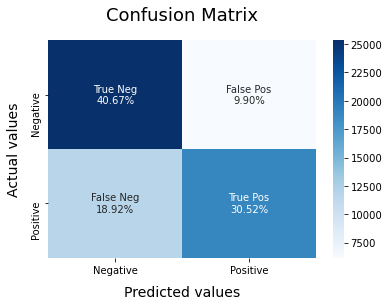

In [78]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     31484
           1       0.74      0.75      0.74     30777

    accuracy                           0.75     62261
   macro avg       0.75      0.75      0.75     62261
weighted avg       0.75      0.75      0.75     62261



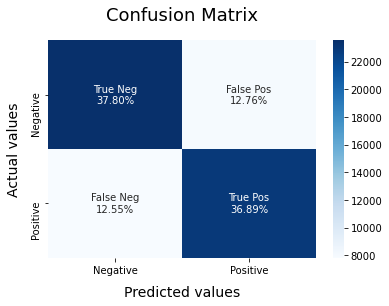

In [25]:
LineSVCmodel = LinearSVC()
LineSVCmodel.fit(X_train, y_train)
model_Evaluate(LineSVCmodel)

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     31484
           1       0.74      0.75      0.75     30777

    accuracy                           0.75     62261
   macro avg       0.75      0.75      0.75     62261
weighted avg       0.75      0.75      0.75     62261



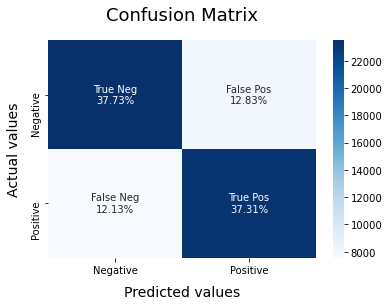

In [77]:
LogModel = LogisticRegression(max_iter=400)
LogModel.fit(X_train, y_train)
model_Evaluate(LogModel)

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.51      1.00      0.67     31484
           1       0.58      0.00      0.00     30777

    accuracy                           0.51     62261
   macro avg       0.54      0.50      0.34     62261
weighted avg       0.54      0.51      0.34     62261



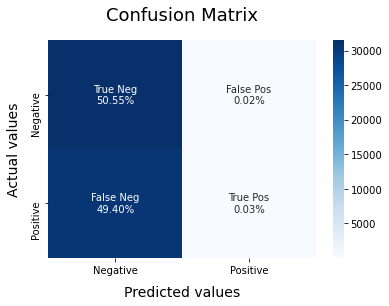

In [76]:
SVCModel = SVC(max_iter=400)
SVCModel.fit(X_train, y_train)
model_Evaluate(SVCModel)

In [80]:
param_grid_SVC = {'C':[1,10,100,1000],
                  'gamma':[1,0.1,0.001,0.0001], 
                  'kernel':['linear','rbf']}

# grid_SVC = GridSearchCV(estimator=SVC(),
#                     param_grid=param_grid_SVC,
#                     scoring='accuracy',
#                     verbose=1,
#                     n_jobs=-1)

# result_grid_SVC = grid_SVC.fit(X_train, y_train)

In [29]:
LogParams = {
    'C':[1.0,10.0,100.0,1000.0],
    'max_iter':[1,10,100,500], 
    'solver':['lbfgs','liblinear','sag','saga'], 
    'penalty':['l1','l2','elasticnet']
}

LinearSVCParams = {
    'penalty':['l1','l2'],
    'loss':['square','squared_hinge'],
    'C':[1.0,10.0,100.0,1000.0],
    'tol':[1e-5,1e-4,1e-3,1e-2,1e-1]
}